SGD를 사용한 MF 기본 알고리즘

In [2]:
import numpy as np
import pandas as pd

def load_ratings() -> "pd.DataFrame":
  """rating df를 불러오는 함수

  Returns:
      pd.DataFrame: user_id, movie_id, rating column을 가지는 df
  """
  r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
  ratings = pd.read_csv('../data2/u.data', names=r_cols, sep='\t', encoding='latin-1')
  ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)
  return ratings

In [53]:
shuffle([1, 2, 3, 4, 5 ,6 , 7])

[5, 6, 7, 2, 1, 3, 4]

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

class MF:
  def __init__(self, ratings: "pd.DataFrame", 
               K:int, alpha:float, beta:float, 
               iterations:int, verbose=True):
    """MF 초기화함수

    Args:
        ratings (DataFrame | Series | array): 평가 데이터 \n
        K (int): # of latent factor \n
        alpha (float): learning rate \n
        beta (float): regularization rate \n
        iterations (int): # of learning \n
        verbose (bool, optional): 학습결과 출력여부. Defaults to True. \n
    """
    self.R = np.array(ratings)
    self.num_users, self.num_items = np.shape(self.R)
    self.K = K; self.alpha = alpha;self.beta = beta
    self.iterations = iterations
    self.verbose = verbose
    
  def rmse(self) -> float:
    """caculate rmse of function

    Returns:
        float: result of rmse
    """
    xs, ys = self.R.nonzero() # 0이 아닌 index를 return해주는 method
    self.predictions = []
    self.errors = []
    
    for x, y in zip(xs, ys):
      prediction = self.get_prediction(x, y)
      self.predictions.append(prediction)
      self.errors.append(self.R[x, y] - prediction)
      
    self.predictions = np.array(self.predictions)
    self.errors = np.square(self.errors) 
    
    return np.sqrt(np.mean(self.errors))
  
  def get_prediction(self, i:int, j:int) -> float:
    """latent matrix(P, Q)를 이용해 R의 i,j 항을 예측하는 함수

    Args:
        i (int): row 
        j (int): column

    Returns:
        float: prediction of r
    """
    prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
    return prediction
  
  def train(self) -> list:
    """train model

    Returns:
        list: results of trains
    """
    # Initializing user-feature and movie-feature latent matrix
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
    
    # Initializing the bias terms
    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])
    
    # List of training samples
    rows, columns = self.R.nonzero()
    self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]
    
    # Stochastic gradient descent for given number of iterations
    training_process = []
    for i in range(self.iterations):
      # self.sample = shuffle(self.samples) # sample을 한번 더 섞어준다. 큰 차이는 없다.
      self.sgd()
      rmse = self.rmse()
      training_process.append((i+1, rmse))
      if self.verbose:
        if (i + 1) % 10 == 0:
          print(f"Iteration {i+1:d} / Train RMSE = {rmse:.4f}")
    
    return training_process
  
  def sgd(self):
    """ P, Q, b_u, b_d를 업데이트하는 함수.
    """
    for i, j, r in self.samples:
      prediction = self.get_prediction(i, j)
      e = (r - prediction)
      
      self.P[i, :] += self.alpha * (2 * e * self.Q[j, :] - self.beta * self.P[i, :])
      self.Q[j, :] += self.alpha * (2 * e * self.P[i, :] - self.beta * self.Q[j, :])
      
      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
      self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])  

In [55]:
ratings = load_ratings()
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

mf = MF(ratings=R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
train_process = mf.train()

Iteration 10 / Train RMSE = 0.9578
Iteration 20 / Train RMSE = 0.9352
Iteration 30 / Train RMSE = 0.9215
Iteration 40 / Train RMSE = 0.9028
Iteration 50 / Train RMSE = 0.8720
Iteration 60 / Train RMSE = 0.8345
Iteration 70 / Train RMSE = 0.7941
Iteration 80 / Train RMSE = 0.7530
Iteration 90 / Train RMSE = 0.7145
Iteration 100 / Train RMSE = 0.6801


Text(0, 0.5, 'rmse')

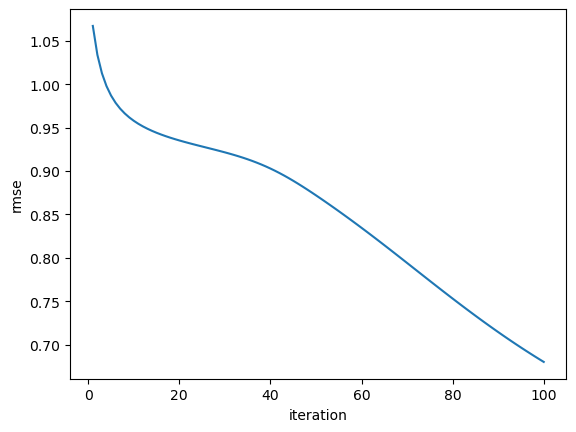

In [56]:
import matplotlib.pyplot as plt

result = pd.DataFrame()

result['iteration'] = [process[0] for process in train_process]
result['rmse'] = [process[1] for process in train_process]
result.set_index('iteration', inplace=True)

plt.plot(result)

plt.xlabel('iteration')
plt.ylabel('rmse')

train/test 분리 MF 알고리즘

In [4]:
class NEW_MF(MF):
  def __init__(self, ratings: "pd.DataFrame", 
               K:int, alpha:float, beta:float, 
               iterations:int, verbose=True):
    super().__init__(ratings, K, alpha, beta, iterations, verbose)
    # 사용자 아이디, 아이템 아이디가 내부의 인덱스와 일치하지 않을 경우를 대비해 
    # 실제 아이디와 내부 인덱스를 매핑해줘야함
    item_id_to_index = []; index_to_item_id = []
    for i, item_id in enumerate(ratings.columns):
      item_id_to_index.append([item_id, i])
      index_to_item_id.append([i, item_id])
    self.item_id_to_index = dict(item_id_to_index); self.index_to_item_id = dict(index_to_item_id)
    
    user_id_to_index = []; index_to_user_id = []
    for i, user_id in enumerate(ratings.index):
      user_id_to_index.append([user_id, i])
      index_to_user_id.append([i, user_id])
    self.user_id_to_index = dict(user_id_to_index); self.index_to_user_id = dict(index_to_user_id)
      
  def set_test(self, ratings_test:"pd.DataFrame") -> "pd.DataFrame":
    """test set 설정하기. test에 쓰이는 것들은 R에서 0으로 바꿔주기

    Args:
        ratings_test (pd.DataFrame): test용 rating df

    Returns:
        pd.DataFrame: test set
    """
    test_set = []
    for i in range(len(ratings_test)):
      x = self.user_id_to_index[ratings_test.iloc[i, 0]]
      y = self.item_id_to_index[ratings_test.iloc[i, 1]]
      z = ratings_test.iloc[i, 2]
      test_set.append([x, y, z])
      self.R[x, y] = 0 # test set에서 사용되는 것들은 학습에 사용되지 않도록 설정하기
    self.test_set = test_set
    
    return test_set
  
  def test_rmse(self) -> float:
    """test set에 대하여 rmse값을 구하는 함수

    Returns:
        float: rmse for test set
    """
    error = 0
    for test_set in self.test_set:
      predicted = self.get_prediction(test_set[0], test_set[1])
      error += pow(test_set[2] - predicted, 2)
    return np.sqrt(error / len(self.test_set))
  
  def test(self) -> list:
    """학습과 동시에 test set에 대한 rmse도 구함

    Returns:
        list: (iter, train rmse, test rmse)의 값을 가진 list
    """
    # Initializing user-feature and movie-feature latent matrix
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
    
    # Initializing the bias terms
    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])
    
    # List of training samples
    rows, columns = self.R.nonzero()
    self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]
    
    # Stochastic gradient descent for given number of iterations
    training_process = []
    for i in range(self.iterations):
      # self.sample = shuffle(self.samples) # sample을 한번 더 섞어준다. 큰 차이는 없다.
      self.sgd()
      rmse = self.rmse()
      rmse2 = self.test_rmse()
      training_process.append((i+1, rmse, rmse2))
      if self.verbose:
        if (i + 1) % 10 == 0:
          print(f"Iteration {i+1:d} / Train RMSE = {rmse:.4f} / Test RMSE = {rmse2:.4f}")
    
    return training_process
  
  def get_one_prediction(self, user_id: int, item_id:int) -> float:
    """한 개의 값에 대한 예측치를 구하는 함수

    Args:
        user_id (int): 유저 id
        item_id (int): 아이템 id

    Returns:
        float: rating 예측치
    """
    return self.get_prediction(self.user_id_to_index[user_id], self.item_id_to_index[item_id])
  
  def full_prediction(self) -> "pd.DataFrame":
    """전체 평점에 대한 예측치를 구하는 함수

    Returns:
        pd.DataFrame: 전체 평점에 대한 예측치
    """
    # np.newaxis를 이용해 2차원으로 변경. np.newaxis가 있는쪽이 1. ex: [:, np.newaxis] -> (5, 1)
    return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)
      

In [86]:
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
cutoff = int(TRAIN_SIZE * len(ratings))

ratings = shuffle(load_ratings(), random_state=1)
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

R_temp = load_ratings().pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

kwargs = {
  'ratings': R_temp,
  'K': 30,
  'alpha': 0.001,
  'beta': 0.02,
  'iterations': 100,
  'verbose': True
}
mf = NEW_MF(**kwargs)

test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration 10 / Train RMSE = 0.9652 / Test RMSE = 0.9834
Iteration 20 / Train RMSE = 0.9391 / Test RMSE = 0.9645
Iteration 30 / Train RMSE = 0.9254 / Test RMSE = 0.9563
Iteration 40 / Train RMSE = 0.9129 / Test RMSE = 0.9509
Iteration 50 / Train RMSE = 0.8950 / Test RMSE = 0.9449
Iteration 60 / Train RMSE = 0.8664 / Test RMSE = 0.9370
Iteration 70 / Train RMSE = 0.8288 / Test RMSE = 0.9296
Iteration 80 / Train RMSE = 0.7870 / Test RMSE = 0.9260
Iteration 90 / Train RMSE = 0.7439 / Test RMSE = 0.9272
Iteration 100 / Train RMSE = 0.7024 / Test RMSE = 0.9327


<AxesSubplot:xlabel='iter'>

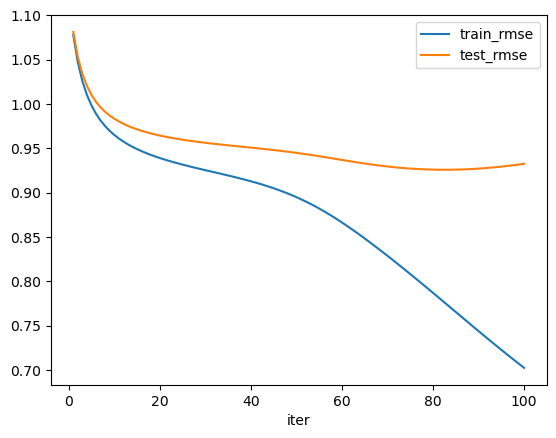

In [91]:
result_df = pd.DataFrame(result, columns=['iter', 'train_rmse', 'test_rmse']).set_index('iter')
result_df.plot()

연습문제   
train/test set을 분리하는 방법을 shuffle() 대신 train_test_split()을 사용.  
결과 분석

In [1]:
from sklearn.model_selection import train_test_split

import sys
sys.path.append('C:/Users/Hi/Desktop/python_recommendation_system/supplement/')
from chapter4_modules import *

TRAIN_SIZE = 0.75

ratings = load_ratings()
split_kwargs = {
  'test_size': 1-TRAIN_SIZE,
  'stratify': ratings['rating']
}

_, test_rating, _, _ = train_test_split(ratings, ratings['rating'], **split_kwargs)

R_temp = load_ratings().pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

mf_kwargs = {
  'ratings': R_temp,
  'K': 30,
  'alpha': 0.001,
  'beta': 0.02,
  'iterations': 100,
  'verbose': True
}
mf = NEW_MF(**mf_kwargs)

test_set = mf.set_test(test_rating)
result = mf.test()

Iteration 10 / Train RMSE = 0.9657 / Test RMSE = 0.9811
Iteration 20 / Train RMSE = 0.9395 / Test RMSE = 0.9621
Iteration 30 / Train RMSE = 0.9255 / Test RMSE = 0.9542
Iteration 40 / Train RMSE = 0.9125 / Test RMSE = 0.9490
Iteration 50 / Train RMSE = 0.8936 / Test RMSE = 0.9431
Iteration 60 / Train RMSE = 0.8638 / Test RMSE = 0.9352
Iteration 70 / Train RMSE = 0.8262 / Test RMSE = 0.9285
Iteration 80 / Train RMSE = 0.7855 / Test RMSE = 0.9257
Iteration 90 / Train RMSE = 0.7437 / Test RMSE = 0.9270
Iteration 100 / Train RMSE = 0.7031 / Test RMSE = 0.9318


<AxesSubplot:xlabel='iter'>

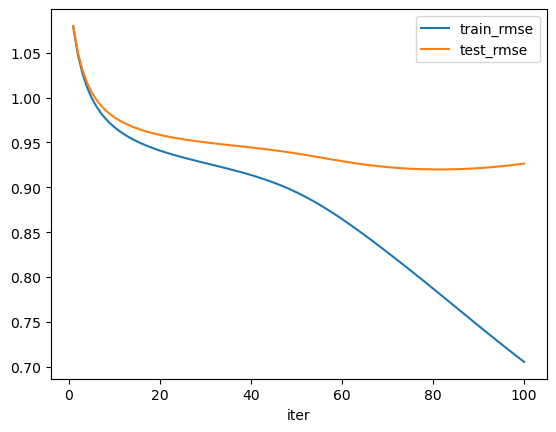

In [101]:
result_df = pd.DataFrame(result, columns=['iter', 'train_rmse', 'test_rmse']).set_index('iter')
result_df.plot()

큰 차이가 없네?

In [2]:
def find_rating_count(df):
  count = []
  tmp = df['rating'].unique() # shuffle로 분리
  for i in tmp:
    count.append([i, df[df['rating'] == i].shape[0]])
  return count

In [3]:
def plot_rating_count(train_count, test_count):
  train_count_df = pd.DataFrame(train_count, columns=['rating', 'count'])
  train_count_df = train_count_df.sort_values(by='rating')

  test_count_df = pd.DataFrame(test_count, columns=['rating', 'count'])
  test_count_df = test_count_df.sort_values(by='rating')

  plt.figure(figsize=(20, 10))

  plt.subplot(1, 2, 1)
  plt.title('train')
  plt.bar(train_count_df['rating'], train_count_df['count'])

  plt.subplot(1, 2, 2)
  plt.title('test')
  plt.bar(test_count_df['rating'], test_count_df['count'])  

[(1, 0.06064), (2, 0.11361333333333333), (3, 0.27028), (4, 0.34201333333333334), (5, 0.21345333333333333)]
[(1, 0.06248), (2, 0.11396), (3, 0.27496), (4, 0.34092), (5, 0.20768)]


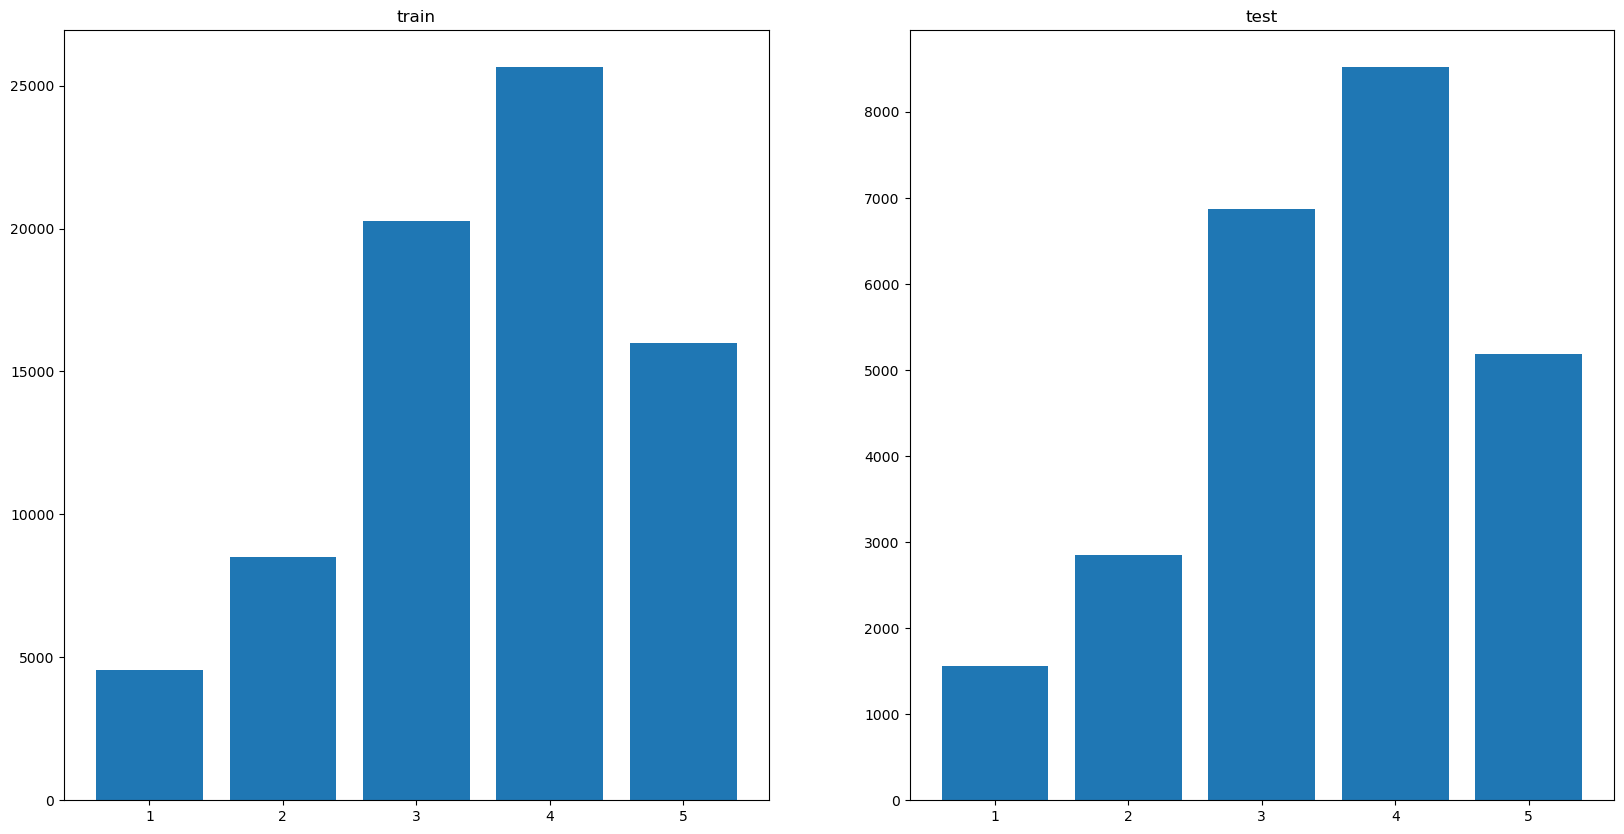

In [28]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

ratings = shuffle(load_ratings(), random_state=1)

TRAIN_SIZE = 0.75
cutoff = int(TRAIN_SIZE * len(ratings))

ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

train_count = find_rating_count(ratings_train)
train_count.sort()
total_count = sum([count[1] for count in train_count])
print([(count[0], count[1] / total_count) for count in train_count])

test_count = find_rating_count(ratings_test)
test_count.sort()
total_count = sum([count[1] for count in test_count])
print([(count[0], count[1] / total_count) for count in test_count])


plot_rating_count(train_count, test_count)

[(1, 0.06064), (2, 0.11361333333333333), (3, 0.27028), (4, 0.34201333333333334), (5, 0.21345333333333333)]
[(1, 0.06112), (2, 0.11372), (3, 0.27144), (4, 0.34172), (5, 0.212)]


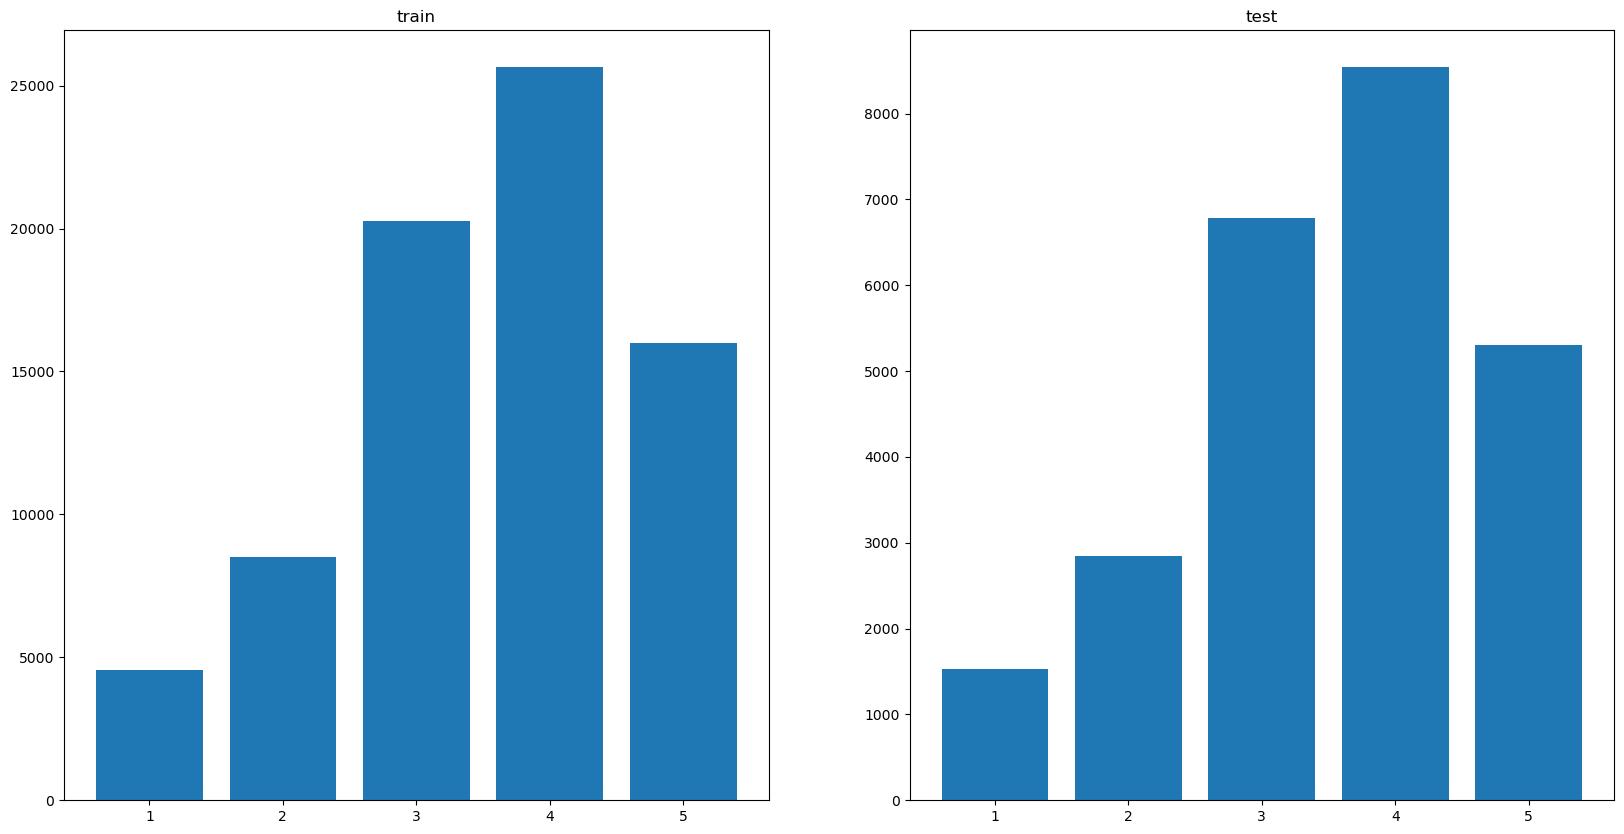

In [26]:
from sklearn.model_selection import train_test_split

ratings = load_ratings()
split_kwargs = {
  'test_size': 1-TRAIN_SIZE,
  'stratify': ratings['rating']
}

rating_train, ratings_test, _, _ = train_test_split(ratings, ratings['rating'], **split_kwargs)

train_count = find_rating_count(ratings_train)
train_count.sort()
total_count = sum([count[1] for count in train_count])
print([(count[0], count[1] / total_count) for count in train_count])

test_count = find_rating_count(ratings_test)
test_count.sort()
total_count = sum([count[1] for count in test_count])
print([(count[0], count[1] / total_count) for count in test_count])


plot_rating_count(train_count, test_count)

MF 최적 파라미터 찾기

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.75
ratings = load_ratings()

split_kwargs = {
  'test_size': 1-TRAIN_SIZE,
  'stratify': ratings['rating']
}

rating_train, ratings_test, _, _ = train_test_split(ratings, ratings['rating'], **split_kwargs)

# results = []; index = []
R_temp = load_ratings().pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

In [10]:
# 시간이 오래걸리니 병렬처리하기 -> ipynb에서는 실행안됨. supplement/chapter4_parallel_processing.py에서 실행.
from multiprocessing import Process
import os

def get_result(K):
  proc = os.getpid()
  print(proc)
  
  mf_kwargs = {
    'ratings': R_temp,
    'K': K,
    'alpha': 0.001,
    'beta': 0.02,
    'iterations':300,
    'verbose':False
  }
  mf = NEW_MF(**mf_kwargs)
  _ = mf.set_test(ratings_test)
  result = mf.test()
  results.append(result)
  
if __name__ == '__main__':
  procs = []
  results = []
  for K in range(50, 261, 10):
    proc = Process(target=get_result, args=(K, ))
    procs.append(proc)
    proc.start()
    
  for proc in procs:
    proc.join()
  

In [16]:
import pickle
import pandas as pd

# supplement/chapter4_parallel_processing.py에서 생성한 pickle 이용. (1h정도 소요됨. cpu=8)
with open('../results/find_K_300.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
K_candidate = range(50, 261, 10)
summary = []

result_df = pd.DataFrame(index=range(1, 301))
for i in range(len(results)):
  K = K_candidate[i]; result = results[i]
  result_df[f'{K}_train_rmse'] = [oneset[1] for oneset in result]
  result_df[f'{K}_test_rmse'] = [oneset[2] for oneset in result]
result_df.head(3)

,50_train_rmse,50_test_rmse,60_train_rmse,60_test_rmse,70_train_rmse,70_test_rmse,80_train_rmse,80_test_rmse,90_train_rmse,90_test_rmse,...,220_train_rmse,220_test_rmse,230_train_rmse,230_test_rmse,240_train_rmse,240_test_rmse,250_train_rmse,250_test_rmse,260_train_rmse,260_test_rmse
1,1.078263,1.080305,1.078179,1.080467,1.077323,1.081883,1.077779,1.080851,1.078966,1.079389,...,1.078989,1.079386,1.077364,1.081867,1.078321,1.080292,1.077963,1.081029,1.078503,1.080128
2,1.047782,1.051612,1.047731,1.051910,1.046696,1.054164,1.046953,1.052810,1.048845,1.050000,...,1.048895,1.049997,1.046777,1.054148,1.047906,1.051599,1.047572,1.052725,1.048185,1.051318
3,1.026696,1.032180,1.026746,1.032501,1.025731,1.035248,1.025701,1.033934,1.028018,1.029995,...,1.028095,1.029991,1.025852,1.035231,1.026884,1.032164,1.026617,1.033429,1.027240,1.031774


In [88]:
# iteration중에서 값이 최소인 것들만 추출하기
min_rmse_series = result_df.min(axis=0)

K_candidate = range(50, 261, 10)
train_min_result = []; test_min_result = []
for K in K_candidate:
  train_min_result.append([K, min_rmse_series[f'{K}_train_rmse']])
  test_min_result.append([K, min_rmse_series[f'{K}_test_rmse']])

train_rmse_df = pd.DataFrame(train_min_result, columns=['K', 'rmse']).set_index('K')
test_rmse_df = pd.DataFrame(test_min_result, columns=['K', 'rmse']).set_index('K')

# 최소값을 갖는 iter 구하기
train_argmin_iters = []
test_argmin_iters = []
for i in range(result_df.shape[1]):
  if (i % 2 ==0): train_argmin_iters.append(result_df.iloc[:, i].argmin())
  else: test_argmin_iters.append(result_df.iloc[:, i].argmin())
    

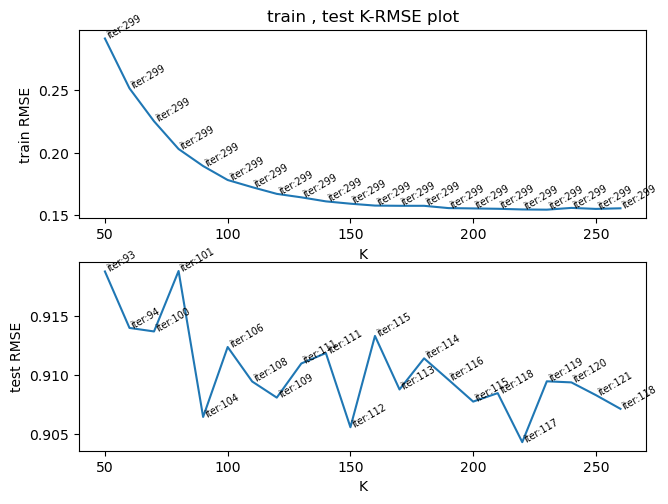

In [89]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].set_title('train , test K-RMSE plot')
axes[0].set_xlabel('K')
axes[0].set_ylabel('train RMSE')

axes[0].plot(train_rmse_df)
for i, argmin_iter in enumerate(train_argmin_iters):
  axes[0].text(train_rmse_df.index[i], train_rmse_df['rmse'].iloc[i], f'iter:{train_argmin_iters[i]}', fontsize='x-small', rotation=30)


axes[1].set_xlabel('K')
axes[1].set_ylabel('test RMSE')

axes[1].plot(test_rmse_df)
for i, argmin_iter in enumerate(test_argmin_iters):
  axes[1].text(test_rmse_df.index[i], test_rmse_df['rmse'].iloc[i], f'iter:{test_argmin_iters[i]}', fontsize='x-small', rotation=30)

plt.show()